The Oxford English Dictionary describes “vibrato” as “a rapid slight variation in
pitch in singing or playing some musical instruments”. The analogy to Monte Carlo
methods is the following: whereas a path simulation in a standard Monte Carlo cal-
culation produces a precise value for the output values from the underlying stochas-
tic process, in the vibrato Monte Carlo approach the output values have a narrow
probability distribution.


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [9]:
from scipy.stats import norm

In [4]:
def savefig(filename):
    plt.savefig('{}.pdf'.format(filename))

In [5]:
# Figures configuration
width = 6
height = width / 1.618

preamble = r"\usepackage[utf8x]{inputenc}, \usepackage[T1]{fontenc}"
plt.rc('pgf', texsystem='pdflatex', preamble=preamble)
plt.rc('figure', figsize=[width, height], autolayout=True)
plt.rc('font', size=13, family='Serif')
plt.rc('text', usetex=True)
plt.rc('lines', linewidth=1.2)
plt.rc('axes.spines', top=False, right=False)
plt.rc('axes', labelsize=14, grid=False, titlesize=16, titlepad=22)
plt.rc('axes3d', grid=False)
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('xtick.minor', visible=True, size=4)
plt.rc('ytick.minor', visible=True, size=4)
plt.rc('xtick.major', size=7.5)
plt.rc('ytick.major', size=7.5)


# Premium Vibrato
For description see article 1

In [72]:
T = 1
K = 100
S = 100
r = 0.05
sigma = .2
M = 1000
Mz = 100
n = 100
def premium_vibrato(S):
    total = 0
    h = T/n
    for i in range(M):
        X = S
        for i in range(n-1):
            Wh = np.random.randn() * np.sqrt(h)
            X *= (1+r*h + sigma * Wh)

        muw = X* (1+r*h)
        sigmaw = X * sigma * np.sqrt(h)
        subtotal = 0
        for j in range(Mz):
            Z = np.random.randn()
            subtotal += max(muw + sigmaw  * Z -K, 0)
        total += subtotal / Mz
    return total/M

In [73]:
data = []
for S in np.linspace(30, 200, 100):
    data.append(premium_vibrato(S))

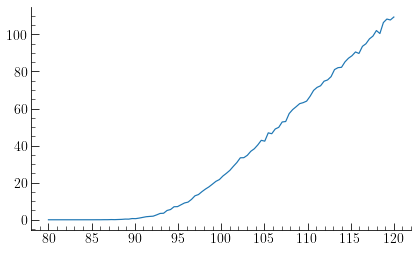

In [74]:
plt.plot(np.linspace(80, 120, 100), data)

In [ ]:
h = T/N;

S = S0*ones(1,M);
tanS0 = ones(1,M);
tanSig = zeros(1,M);
tanS0Sig = zeros(1,M);

%First lets Euler-Maruyama the process and associated tangent processes.
%Note the second order tangent process with respect to S0 will be
%identically zero, as the intial condition will be zero, and it takes the
%same form as tanS0
for n=1:(N-1)
   dW = sqrt(h)*randn(1,M);
   tanSig = tanSig.*(1+mu*h+sig*dW) + S.*dW;
   tanS0Sig = tanS0Sig.*(1+mu*h+sig*dW) + tanS0.*dW;
   tanS0 = tanS0.*(1+mu*h+sig*dW);
   S = S.*(1+mu*h+sig*dW);
end

Z = randn(d,M);

muw = S*(1+mu*h); %array of drift of final timesteps for each path
sigmaw = S*(sig*sqrt(h)); %array of vols of final timestep

dmuw = tanS0*(1+mu*h); % S0 tangent drifts
dsigmaw = tanS0*(sig*sqrt(h)); % vols

vmuw = tanSig*(1+mu*h); %Same for the sigma tangent
vsigmaw = tanSig*(sig*sqrt(h)) + S*sqrt(h);

vamuw = tanS0Sig*(1+mu*h); %Same for the S0-sigma tangent
vasigmaw = tanS0Sig*(sig*sqrt(h)) + tanS0*sqrt(h);

Sp=ones(d,1)*muw+(ones(d,1)*sigmaw).*Z;
Sm=ones(d,1)*muw-(ones(d,1)*sigmaw).*Z;
Sneutral=ones(d,1)*muw;
%The above quantities are used for the calculation of antithetic variables
%later, to speed up convergence

switch flavor
    case 'vanilla'
        fSp = exp(-mu*T)*(0.5)*(1+ sign(Sp-K)).*(Sp-K);
        fSm = exp(-mu*T)*(0.5)*(1 + sign(Sm - K)).*(Sm-K); %These are payoff values
        fmuw = exp(-mu*T)*(0.5)*(1 + sign(Sneutral - K)).*(Sneutral-K);
    case 'digital'
        fSp = exp(-mu*T)*(0.5)*(1 + sign(Sp - K));
        fSm = exp(-mu*T)*(0.5)*(1 + sign(Sm - K)); 
        fmuw = exp(-mu*T)*(0.5)*(1 + sign(Sneutral - K));
    otherwise
        error('Invalid payoff time. Currently "digital" or "vanilla" is supported')
end
    
oddAntithetic = fSp - fSm; % For terms where the polynomial in Z is odd
evenAntithetic = fSp - 2*fmuw + fSm; % When its even, subtract the 2 to
%stay O(1)

switch greek %Section 2.2-2.3 for explanation of 1st order, 2.4 for 2nd
    case 'delta'
        Ymu = Z.*(ones(d,1)*(1./sigmaw))*(1/2).*(oddAntithetic);
        Ysigma = (Z.^2-1).*(ones(d,1)*(1./sigmaw))*(1/2).*(evenAntithetic);
        deltMat = (ones(d,1)*dmuw).*Ymu + (ones(d,1)*dsigmaw).*Ysigma;
        valsDelta = 1/d*sum(deltMat);
        value = sum(valsDelta)/M;
        variance=(1/M)*(1/M*sum(valsDelta.^2)-(value)^2)+1/(M*d)...
        *1/M*sum(sum(deltMat.^2)/d-valsDelta.^2);
    case 'vega'
        Ymu = Z.*(ones(d,1)*(1./sigmaw))*(1/2).*(oddAntithetic);
        Ysigma = (Z.^2-1).*(ones(d,1)*(1./sigmaw))*(1/2).*(evenAntithetic);
        vegaMat = (ones(d,1)*vmuw).*Ymu + (ones(d,1)*vsigmaw).*Ysigma;
        valsVega = 1/d*sum(vegaMat);
        value = sum(valsVega)/M;
        variance=(1/M)*(1/M*sum(valsVega.^2)-(value)^2)+1/(M*d)...
        *1/M*sum(sum(vegaMat.^2)/d-valsVega.^2);
    case 'gamma'
        Ymusquare = (Z.^2-1).*(ones(d,1)*(1./(sigmaw.^2)))*(1/2).*(evenAntithetic);
        Ysigmasquare = (Z.^4-5.*Z.^2 - 2).*(ones(d,1)*(1./(sigmaw.^2)))*(1/2).*(evenAntithetic);
        Ymixed = (Z.^3-3.*Z).*(ones(d,1)*(1./(sigmaw.^2)))*(1/2).*(oddAntithetic);
        gammaMat = (ones(d,1)*(dmuw.^2)).*Ymusquare + ...
        (ones(d,1)*(dsigmaw.^2)).*Ysigmasquare + ...
        2.*(ones(d,1)*(dmuw.*dsigmaw)).*Ymixed;
        valsGamma = 1/d*sum(gammaMat);
        value = sum(valsGamma)/M;
        variance=(1/M)*(1/M*sum(valsGamma.^2)-(value)^2)+1/(M*d)...
        *1/M*sum(sum(gammaMat.^2)/d-valsGamma.^2);
    case 'vanna'
        Ydoublemu = (Z).*(ones(d,1)*(1./(sigmaw)))*(1/2).*(oddAntithetic);
        Ydoublesigma = (Z.^2-1).*(ones(d,1)*(1./(sigmaw)))*(1/2).*(evenAntithetic);
        Ymusquare = (Z.^2-1).*(ones(d,1)*(1./(sigmaw.^2)))*(1/2).*(evenAntithetic);
        Ysigmasquare = (Z.^4-5.*Z.^2 - 2).*(ones(d,1)*(1./(sigmaw.^2)))*(1/2).*(evenAntithetic);
        Ymixed = (Z.^3-3.*Z).*(ones(d,1)*(1./(sigmaw.^2)))*(1/2).*(oddAntithetic);
        vannaMat = (ones(d,1)*(vamuw)).*Ydoublemu + ...
        (ones(d,1)*(dmuw.*vmuw)).*Ymusquare + ...
        (ones(d,1)*(vasigmaw)).*Ydoublesigma + ...
        (ones(d,1)*(dsigmaw.*vsigmaw)).*Ysigmasquare + ...
        (ones(d,1)*(dmuw.*vsigmaw + vmuw.*dsigmaw)).*Ymixed;
        valsVanna = 1/d*sum(vannaMat);
        value = sum(valsVanna)/M;
        variance=(1/M)*(1/M*sum(valsVanna.^2)-(value)^2)+1/(M*d)...
        *1/M*sum(sum(vannaMat.^2)/d-valsVanna.^2);
    otherwise
        error('Invalid Greek. Delta, gamma, vega and vanna are currently supported');
end